In [1]:
%matplotlib inline
from os import listdir
from os.path import isfile, join
import numpy as np
from glob import glob
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib
import statsmodels.stats.multitest as smt
from sklearn.decomposition import PCA
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams['figure.dpi'] = 100

## 0. Read samples location info

In [2]:
def read_samples_info(dir_path, file_name):
    file_data = glob(dir_path + file_name)[0]
    INFO = pd.read_csv(file_data, sep='\t')[['sample_ID', 'rookery-region', 'Year', 'group-Lkadj', 
                                         'Management units - based on DNA', 'Post_dupe_depth_2_all_LKGATK_USE',
                                         'Exclude-all_GL_ROH_analyses', 'Sequencing_source-type', 'Stage_Class']]
    INFO.rename(columns={'sample_ID':'sample', 
                     'rookery-region':'rookery', 
                     'Year':'year',
                     'group-Lkadj': 'group',
                     'Management units - based on DNA': 'MU',
                     'Post_dupe_depth_2_all_LKGATK_USE':'depth',
                     'Exclude-all_GL_ROH_analyses': 'exclude',
                     'Sequencing_source-type': 'batch',
                     'Stage_Class': 'stage'}, inplace=True)
    return INFO

## 1. PCA analysis

### 1.1. Read PCA eigenvectors and eigenvalues

In [3]:
rookery_palette_dict = {
    'Mexico': '#1f77b4',
    'Atl Costa Rica': '#005a32',
    'Indonesia': '#d62728',
    'Pacific Costa Rica': '#7570b3',
    'Papua New Guinea': '#dd3497',
    'Solomon Islands': '#fde0dd',
    'Malaysia': '#2ca02c',
    'South Africa': '#17becf',
    'Ghana': '#ff7f0e',
    'Gabon': '#fdd0a2',   
    'French Guiana-Suriname': '#8c564b',
    'Virgin Islands': '#d6eaf8',
    'Florida': '#d9f0a3',
    'na': '#000000',
    'unknown': '#7f7f7f'}

mu_palette_dict = {
    'Eastern Pacific': '#1f77b4',
    'Western Pacific': '#d62728',
    'Northwest Caribbean': '#005a32',
    'Northeast Caribbean': '#6a51a3',
    'Northern Caribbean': '#d9f0a3',
    'South Africa': '#17becf',
    'SE Atlantic/West Africa': '#ff7f0e',
    'South-east Caribbean': '#8c564b',
    'Indo-Western Pacific': '#2ca02c',
    'na': '#000000',
    'unknown': '#7f7f7f'}

batch_palette_dict = {
    'novo_UMass_Illumina_SR': '#1f77b4',
    'novo42_Illumina_SR': '#ff7f0e',
    'LR-getinfofromJH': '#2ca02c',
    'Duffy_Illumina_SR': '#d62728'}

population_palette_dict = {
    'larger_declining': '#d62728',
    'small_stable':'#1f77b4',
    'small_declining': '#005a32',
    'larger_stable': '#ff7f0e',
    'small_recovering': '#6a51a3'}

color_dict = {'MU': mu_palette_dict,
              'rookery': rookery_palette_dict,
              'batch': batch_palette_dict,
              'pops': population_palette_dict}

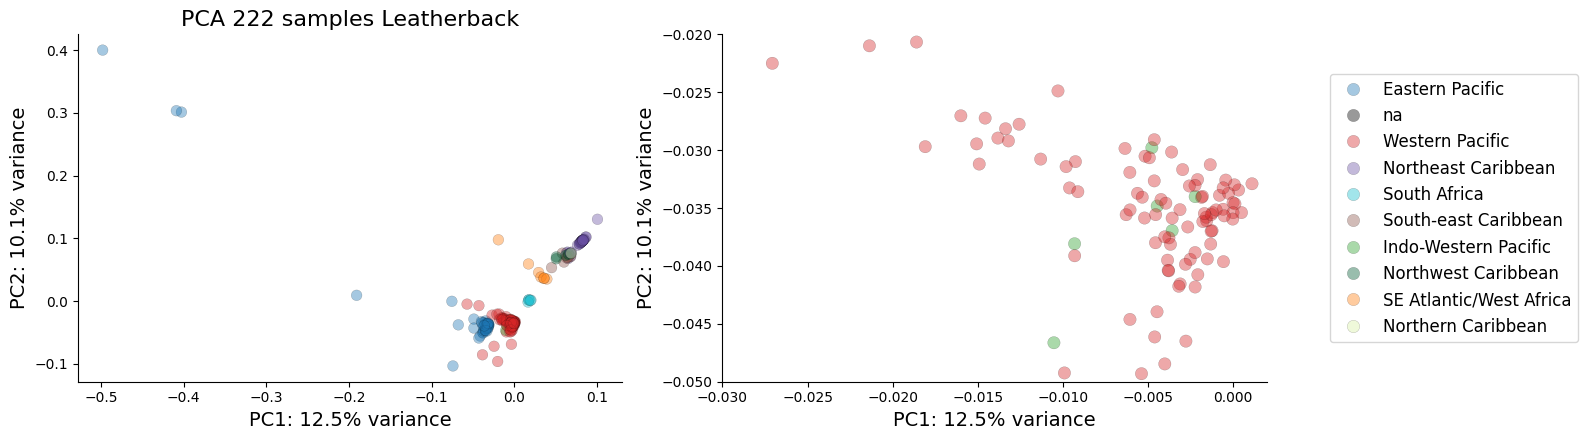

In [11]:
dir_path = '/Users/osipova/Documents/LabDocs/Leatherback_popgen/'

# group = 'batch'
group = 'MU'
# group = 'rookery'
p = color_dict[group]

fig, axes = plt.subplots(1, 2, figsize=(16, 4.5))

derCor = '222'
# derCor = 'Caribbean'

## Read location info
file_name_info = f'dc_222_samples_info.tsv'
INFO = read_samples_info(dir_path, file_name_info)

## Read eigenvectors
file_name_eigenvec = f'PCA/pca.ld_pruned_0.2.derCor_{derCor}.eigenvec'
file_data = glob(dir_path + file_name_eigenvec)[0]
df = pd.read_csv(file_data, sep=' ', header=None)

## Assign column names
df = df.iloc[:, 1:]
num_pcs = df.shape[1]
column_names = ['sample'] + [f'PC{i}' for i in range(1, num_pcs)]
df.columns = column_names

## Assign location to each sample
df_all = pd.merge(df, INFO, on='sample')

## Exclude samples that are not for genetic load analysis
df_all['exclude'] = df_all['exclude'].fillna('include')
#     dfi = df_all[df_all['exclude'] == 'include']
dfi = df_all

## Read eigenvalues
file_name_eigenval = f'PCA/pca.ld_pruned_0.2.derCor_{derCor}.eigenval'
eigenval = [float(l.strip()) for l in open(dir_path + file_name_eigenval, 'r')]
variance = [l / sum(eigenval) * 100 for l in eigenval]

for k in range(2):

    ## Plot PCx vs PCy
    j = 0
    ax = axes[k]
    if k == 0:
        s = 60
    elif k == 1:
        s = 80

    sns.scatterplot(ax=ax, data=dfi, x=f'PC{2*j+1}', y=f'PC{2*j+2}', hue=group, 
                    s=s, edgecolor='k', linewidth=0.2, alpha=0.4, palette=p)

    ax.set_xlabel(f'PC{2*j+1}: {variance[2*j]:.1f}% variance', fontsize=14)
    ax.set_ylabel(f'PC{2*j+2}: {variance[2*j+1]:.1f}% variance', fontsize=14)

    if k == 1:
        ## Plot zoom-in
        ax.set_xlim(-0.03, 0.002)
        ax.set_ylim(-0.05, -0.02)
        ax.legend(loc="center left", bbox_to_anchor=(1.1, 0.5), fontsize=12)
    else:
        ax.set_title(f"PCA {derCor} samples Leatherback", fontsize=16)
        ax.get_legend().remove()

sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

pdf_name = f'PCA_{derCor}_included_only.{group}.pdf'
# fig.savefig(pdf_name, bbox_inches='tight')
plt.show()

## 2. Admixture analysis

In [36]:
rookery_order = ['Mexico', 'Pacific Costa Rica', 'Atl Costa Rica', 'Virgin Islands', 
                 'French Guiana-Suriname', 'Florida',
                'Ghana', 'Gabon', 'South Africa', 
                 'Malaysia', 'Indonesia', 'Papua New Guinea', 'Solomon Islands', 'unknown']

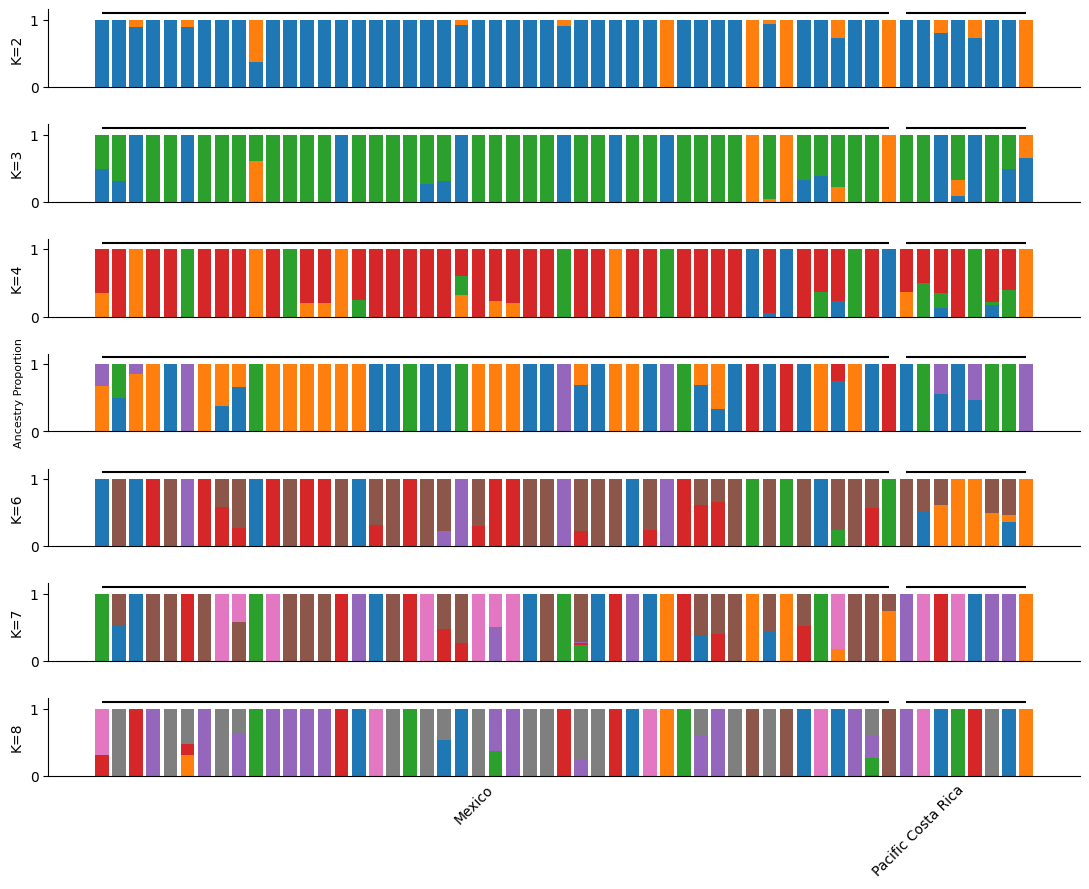

In [39]:
dir_path = '/Users/osipova/Documents/LabDocs/Leatherback_popgen/'
dc = '222'
out_dir = f"Admixture_{dc}/"
k_values = range(2, 9)
group = 'rookery'


fig, axes = plt.subplots(len(k_values), 1, figsize=(11, 9))

for i in range(len(k_values)):
    k = k_values[i]
    
    # Load Q matrix
    file_name = f"named.filt.EP.ld_pruned_0.2.derCor_{dc}.{k}.Q"
    file_data = glob(dir_path + out_dir + file_name)[0]
    q_matrix = pd.read_csv(file_data, sep="\t", names=['sample'] + list(range(1, k+1)), index_col=False)
    df_q = pd.merge(q_matrix, INFO, on='sample')
    # Sort by rookery order:
    df_q[group] = pd.Categorical(df_q[group], categories=rookery_order, ordered=True)
    df_q.sort_values(group, inplace=True, ignore_index=True)  # Enforces the custom order
    ax = axes[i]
    
    # Stacked bar plot for each individual
    bottom = pd.Series(0, index=df_q.index)
    for cluster in range(1, k+1):
        ax.bar(df_q.index, 
               df_q[cluster], 
               bottom=bottom)
        bottom += df_q[cluster]
    
#     ax.set_title(f"ADMIXTURE (K={k})", fontsize=14)
    ax.set_ylabel(f"K={k}")
    if i == 3:
        ax.set_ylabel("Ancestry Proportion", fontsize=8)
    ax.set_xticks([])


    # Calculate midpoints for country labels
    all_groups = [g for g in rookery_order if g in set(df_q[group])]
    positions = []
    labels = []
    line_ranges = []

    for g in all_groups:
        subset = df_q[df_q[group] == g]
        midpoint = (subset.index[0] + subset.index[-1]) / 2
        positions.append(midpoint)
        labels.append(g)
        line_ranges.append((subset.index[0], subset.index[-1]))

    # Add horizontal lines above the plot
    line_y = 1.1
    for start, end in line_ranges:
        ax.hlines(y=line_y, xmin=start, xmax=end, color='black', linewidth=1.5)

    # Add country labels
    if i == len(k_values) - 1:
        for pos, label in zip(positions, labels):
            ax.text(pos, -0.1, label, ha='right', va='top', rotation=45)
    
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

# pdf_name = f'Admixture_222_all.{group}.pdf'
pdf_name = f'Admixture_EP_all.{group}.pdf'
# fig.savefig(pdf_name, bbox_inches='tight')